#### Data load/preprocessing

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 로드 및 전처리 -------------------------------------------------
# 1-1. 타이타닉 데이터 로드
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print("train_data:") 
print(train_data.head())

print("\ndata info:")
train_data.info()

# basic stats 
print("\n기본 통계: ")
print(train_data.describe()) 

# 1-2. 결측치 찾기 
print("\n결측치 갯수:")
print(train_data.isnull().sum())

train_data:
   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Far

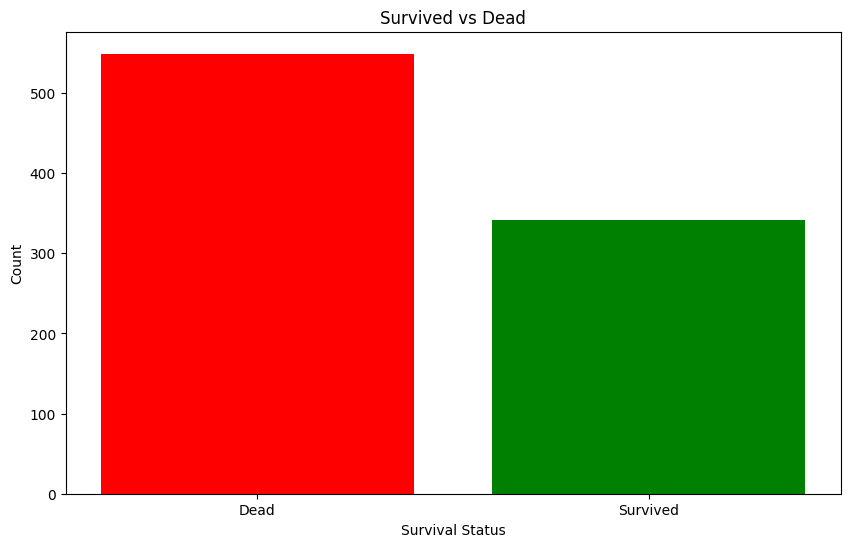

In [22]:
# NaN 값 처리 및 EDA
# 생존 여부 시각화 (Survived vs Dead)
plt.figure(figsize=(10, 6))
survival_counts = train_data['Survived'].value_counts()
plt.bar(['Dead', 'Survived'], survival_counts, color=['red', 'green'])
plt.title('Survived vs Dead')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.show()

# 



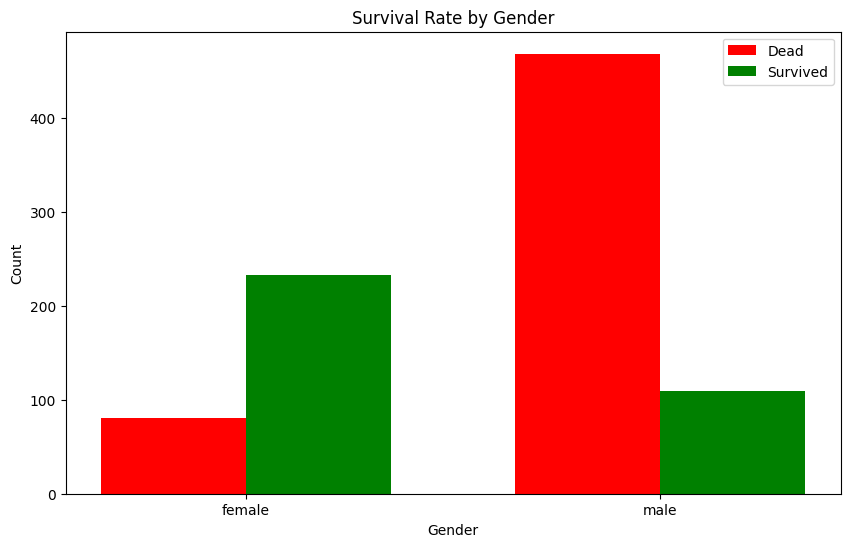

In [23]:
# 성별에 따른 생존율
plt.figure(figsize=(10, 6))
gender_survival = train_data.groupby(['Sex', 'Survived']).size().unstack()

bar_width = 0.35
x = np.arange(len(gender_survival.index))

plt.bar(x - bar_width/2, gender_survival[0], bar_width, label='Dead', color='red')
plt.bar(x + bar_width/2, gender_survival[1], bar_width, label='Survived', color='green')

plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(x, gender_survival.index)
plt.legend()
plt.show()

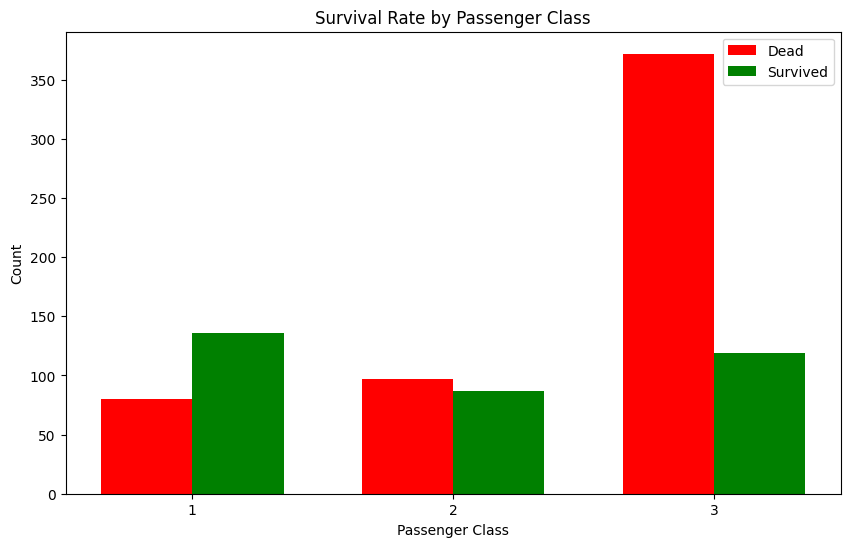

In [24]:
# 승객 등급(Pclass)에 따른 생존율
plt.figure(figsize=(10, 6))
pclass_survival = train_data.groupby(['Pclass', 'Survived']).size().unstack()

bar_width = 0.35
x = np.arange(len(pclass_survival.index))

plt.bar(x - bar_width/2, pclass_survival[0], bar_width, label='Dead', color='red')
plt.bar(x + bar_width/2, pclass_survival[1], bar_width, label='Survived', color='green')

plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.xticks(x, pclass_survival.index)
plt.legend()
plt.show()


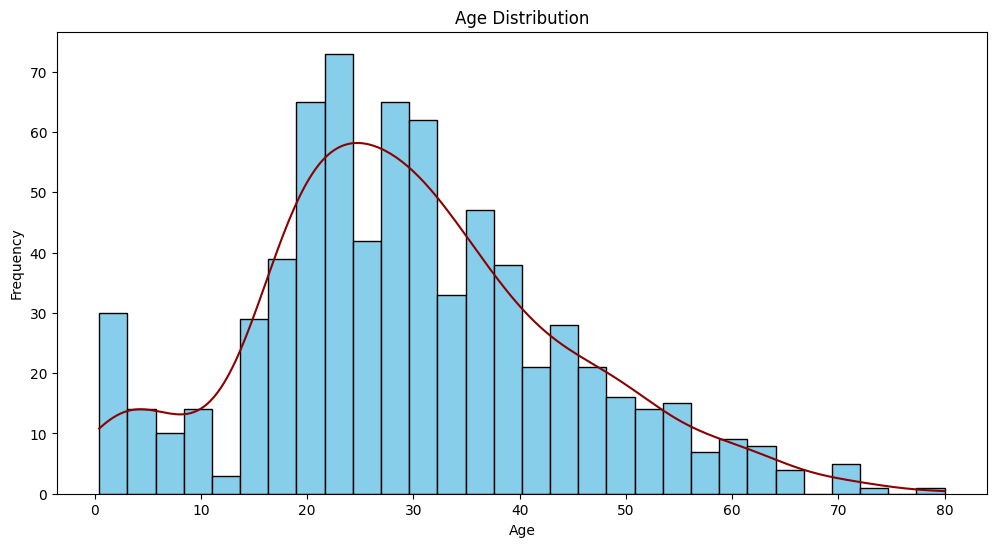

In [25]:
# 나이 분포 - 결측치 제외
plt.figure(figsize=(12, 6))
age_data = train_data['Age'].dropna()
n, bins, patches = plt.hist(age_data, bins=30, color='skyblue', edgecolor='black')

# 커널 밀도 추정 곡선 추가
from scipy.stats import gaussian_kde
kde = gaussian_kde(age_data)
x_vals = np.linspace(age_data.min(), age_data.max(), 300)
plt.plot(x_vals, kde(x_vals)*len(age_data)*(bins[1]-bins[0]), color='darkred')

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()



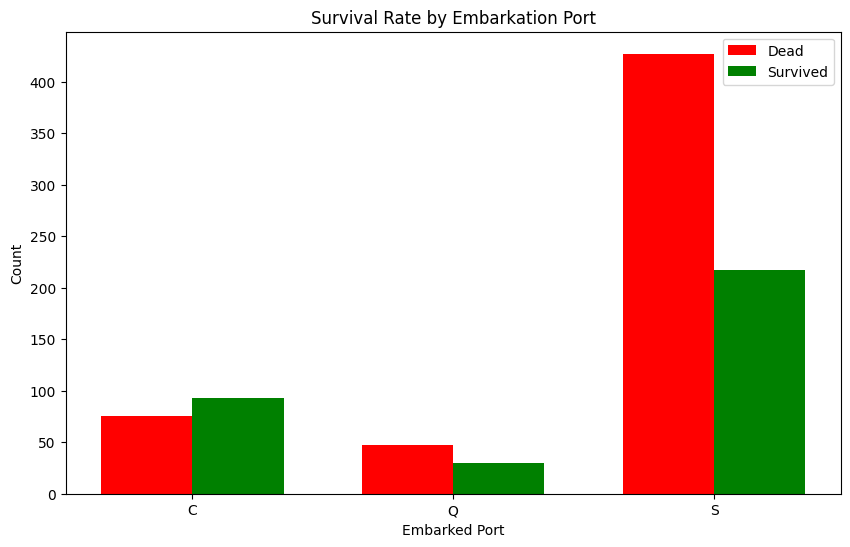

In [26]:
# 승선 항구(Embarked)에 따른 생존율
plt.figure(figsize=(10, 6))
embarked_survival = train_data.groupby(['Embarked', 'Survived']).size().unstack()

bar_width = 0.35
x = np.arange(len(embarked_survival.index))

plt.bar(x - bar_width/2, embarked_survival[0], bar_width, label='Dead', color='red')
plt.bar(x + bar_width/2, embarked_survival[1], bar_width, label='Survived', color='green')

plt.title('Survival Rate by Embarkation Port')
plt.xlabel('Embarked Port')
plt.ylabel('Count')
plt.xticks(x, embarked_survival.index)
plt.legend()
plt.show()

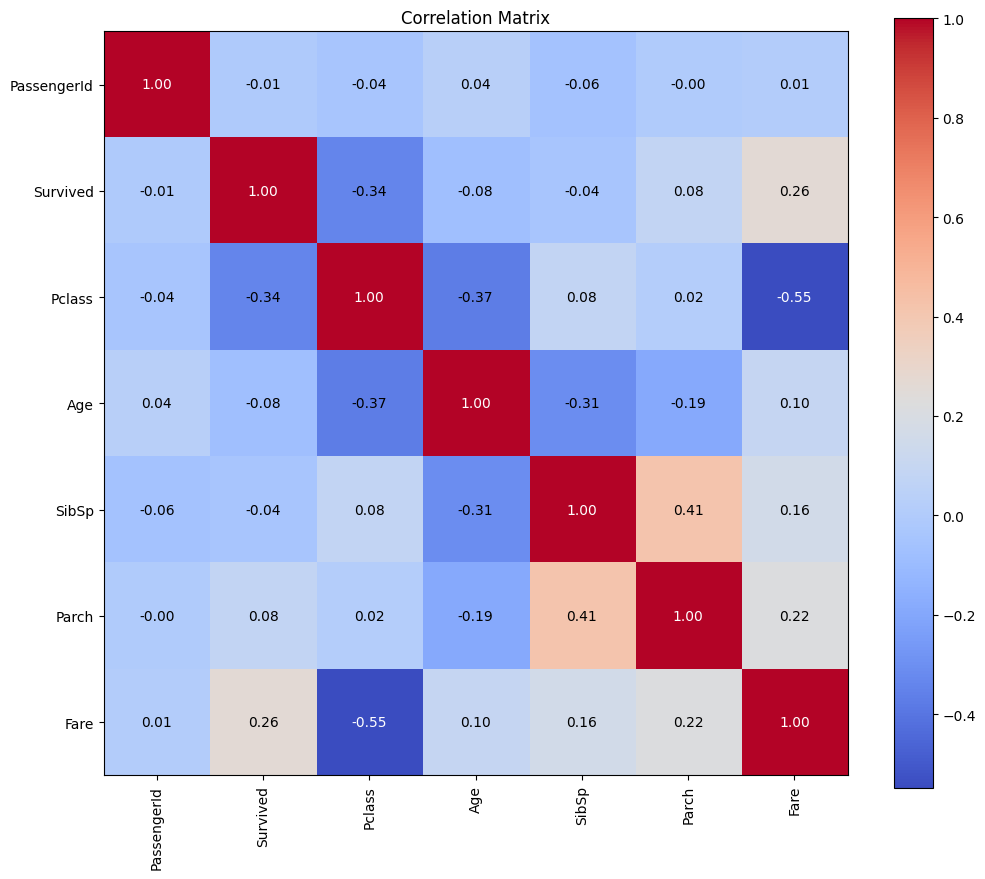

In [27]:
# 상관관계 분석 - 수치형 변수만
numeric_data = train_data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)

# 값 텍스트 추가
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", 
                ha='center', va='center', 
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
plt.show()

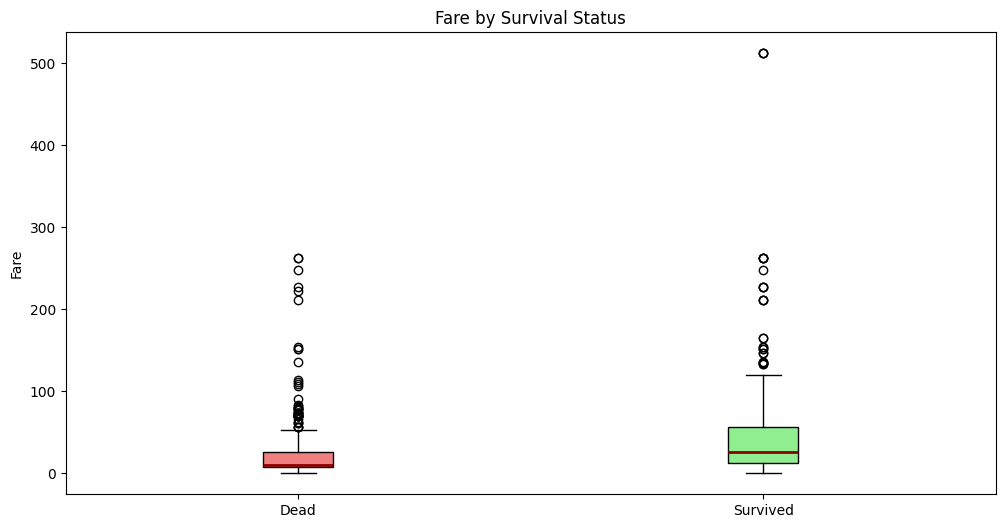

In [28]:
# 생존율과 요금(Fare)의 관계
plt.figure(figsize=(12, 6))
fare_data = [train_data[train_data['Survived'] == 0]['Fare'].dropna(),
            train_data[train_data['Survived'] == 1]['Fare'].dropna()]

box = plt.boxplot(fare_data, 
                patch_artist=True,
                labels=['Dead', 'Survived'])

# 박스 색상 설정
colors = ['lightcoral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# 중앙선 색상 설정
for median in box['medians']:
    median.set(color='darkred', linewidth=2)

plt.title('Fare by Survival Status')
plt.ylabel('Fare')
plt.show()

#### 3. Data Preprocessing

In [29]:
# 모든 데이터 합치기 
test_data['Survived'] = np.nan 
combined_data = pd.concat([train_data,test_data],axis=0) 

# 특성 엔지니어링: 'Name'에서 호칭(Title) 추출
combined_data['Title'] = combined_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 호칭 매핑 및 그룹화
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Mlle': 'Miss',
    'Countess': 'Mrs',
    'Ms': 'Miss',
    'Lady': 'Mrs',
    'Jonkheer': 'Officer',
    'Don': 'Officer',
    'Dona': 'Mrs',
    'Mme': 'Mrs',
    'Capt': 'Officer',
    'Sir': 'Officer'
}
combined_data['Title'] = combined_data['Title'].map(title_mapping)

# 가족 크기 특성 생성
combined_data['FamilySize'] = combined_data['SibSp'] + combined_data['Parch'] + 1
combined_data['IsAlone'] = (combined_data['FamilySize'] == 1).astype(int)

# 연령대 특성 생성 (Age 결측치는 중앙값으로 채움)
combined_data['Age'] = combined_data.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

# 승선 항구(Embarked) 결측치 처리 - 가장 많이 나오는 값으로 대체
combined_data['Embarked'] = combined_data['Embarked'].fillna(combined_data['Embarked'].mode()[0])

# 요금(Fare) 결측치 처리 - Pclass 기준 중앙값으로 대체
combined_data['Fare'] = combined_data.groupby('Pclass')['Fare'].transform(
    lambda x: x.fillna(x.median())
)

# 필요한 특성만 선택
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']
# 다시 train/test 데이터로 분리
train_processed = combined_data[combined_data['Survived'].notna()]
test_processed = combined_data[combined_data['Survived'].isna()]

X_train = train_processed[features]
y_train = train_processed['Survived'].astype(int)
X_test = test_processed[features]

### 4. 모델 선택 및 학습 (fitting) 

In [30]:
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']


numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num',numeric_transformer, numeric_features),
        ('cat',categorical_transformer, categorical_features)
    ]
)

# 랜덤 포레스트 모델 파이프라인
rf_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor), 
    ('classifier',RandomForestClassifier(random_state=42))
])
# XGBoost 모델 파이프라인
xgb_pipeline = Pipeline(steps=[
    ('preprocesssor',preprocessor),
    ('classifier',xgb.XGBClassifier(random_state=42))
])

# 교차 검증으로 모델 평가
rf_scores = cross_val_score(rf_pipeline,X_train, y_train,cv=5,scoring='accuracy')
print(f"랜덤 포레스트 교차 검증 정확도: {rf_scores.mean():.4f} (±{rf_scores.std():.4f})")

xgb_scores = cross_val_score(xgb_pipeline,X_train,y_train,cv=5,scoring='accuracy')
print(f"XGBoost 교차 검증 정확도: {xgb_scores.mean():.4f} (±{xgb_scores.std():.4f})")

# 모델 학습 (더 좋은 성능을 보인 모델 선택)
if rf_scores.mean() > xgb_scores.mean():
    best_model = rf_pipeline
    print("랜덤 포레스트 모델을 최종 선택했습니다.")
else:
    best_model = xgb_pipeline
    print("XGBoost 모델을 최종 선택했습니다.")

best_model.fit(X_train, y_train)

랜덤 포레스트 교차 검증 정확도: 0.8047 (±0.0236)
XGBoost 교차 검증 정확도: 0.8137 (±0.0255)
XGBoost 모델을 최종 선택했습니다.


Pipeline(steps=[('preprocesssor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare',
                                                   'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Tit...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

#### 5. Predict

In [31]:
# 테스트 데이터에 대한 예측
predictions = best_model.predict(X_test) 

# 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'], 
    'Survived': predictions
})
submission.to_csv('submission.csv',index=False)
print("예측 완료! submission.csv 파일이 생성되었습니다.")


예측 완료! submission.csv 파일이 생성되었습니다.


#### 6. 성능 개선 

In [32]:
# 하이퍼파라미터 튜닝을 위한 그리드 서치 (XGBoost 예시)
param_grid = {
    'classifier__n_estimators':[100,200,300],
    'classifier__max_depth':[3,5,7],
    'classifier__learning_rate':[0.01,0.1,0.2],
    'classifier__subsample':[0.8,0.9,1.0],
    'classifier__colsample_bytree':[0.8,0.9,1.0]
}

grid_search = GridSearchCV(
    xgb_pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1 
)
# 그리드 서치 실행 (시간이 오래 걸릴 수 있음)
# 실제 환경에서는 아래 코드의 주석을 해제하고 실행
grid_search.fit(X_train, y_train)
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"최고 정확도: {grid_search.best_score_:.4f}")

# 특성 중요도 시각화 (랜덤 포레스트 모델 사용)
if isinstance(best_model.named_steps['classifier'], RandomForestClassifier):
    rf_model = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']
    
    # 전처리된 특성 이름 가져오기
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if hasattr(transformer.named_steps.get('onehot', None), 'get_feature_names_out'):
            # 범주형 특성의 경우 원핫 인코딩된 컬럼명
            cat_features = transformer.named_steps['onehot'].get_feature_names_out(features)
            feature_names.extend(cat_features)
        else:
            # 수치형 특성
            feature_names.extend(features)
    
    # 특성 중요도 시각화
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
최적 하이퍼파라미터: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
최고 정확도: 0.8473
